# Emotions Go Particles
This notebook analyzes data generated from a study wherein people with schizophrenia and healthy controls were both instructed to watch a series of short videos (of varying emotional valence), then describe the videos and their reactions to the videos on camera. The videos were split into two groups; healthy controls (HC) watched only one group of videos (randomly assigned). The people with schizophrenia (PT for patients) watched both, each on separate days. On one of those days they had intranasal oxytocin administered to them, and on the other they were given a saline placebo. 

A team used an NLP emotion recognition model to summarize each subjects description of each stimulus with which they were presented into a vector of 28 emotions (including "no emotion"). Here, we coarsen that to 4 emotion groups (positive, negative, neutral, ambiguous) by simply summing, as the intial output is just a distribution.

The analysis presented here builds off of prior research indicating that people with schizophrenia may "mismap" emotions, particularly neutral or ambiguous emotions. Because we do not have any ground truth for the emotional content of the stimuli, we compare the reactions of the PTs to a "normative" response infered from the reactions of the HCs.

At a high level, we first assume that each stimulus has a fixed but unknown emotional distribution. We assume that HCs report that distribution back with only a small, unbiased (over the HC population) "random effect" noising plus some further measurement noise. We assume that there is some pre-noising/rotation of the stimuli's emotional distributions that occurs uniformly for all PTs prior to their "random effect" noising and the measurement noise. For oxytocin (OT), we add another unobserved rotation after the SZ rotation but before the "random effect" one.

## Notation and assumptions
* Set of stimuli $\left\{ i \right\}$
* Dirichlet prior param $\alpha$ 
  * We make extensive use of the [dirichlet distribution](https://en.wikipedia.org/wiki/Dirichlet_distribution), which is a distribution over distrubtions over finite, discrete outcomes or choices; in our case these are the 4 emotion groups.
* Random effect prior gamma prior means $\bar{\mu}^{re,d}$ and $\bar{\mu}^{re,r}$, for diagonal and off diagonal respectively
  * Details below, but these basically define our prior belief on how much an average person correctly identifies vs "misunderstands" a given emotional signal.
* Model precision magnitude param $\bar{o}$
* $\mathbf{1}_{4}=(1,1,1,1)$ and $\mathbf{e}_{2}=(0, 1, 0, 0)$ are a 1-vector and an axis or dimension vector.
* $\Delta^{3}$ is the 3 [simplex](https://en.wikipedia.org/wiki/Simplex), ie the space of vectors $\vec{u}$ of length 4 where $u_{1},u_{2},u_{3},u_{4}\geq 0$ and $u_{1}+u_{2}+u_{3}+u_{4}=1$

For each stimulus $i$ we have an emotion distribution $\vec{p}_{i}\in\Delta^{3}$ with prior
* $\vec{p}_{i} \sim Dir\left(\left(\alpha /4 \right) \mathbf{1}_{4} \right)$.

For patients with schizophrenia, we assume there is a "screen" between them and the video that "rotates" the video's emission distribution such that a particle of emotion $j$ emitted by the video and intercepted by this screen has an emission distribution of 
* $\vec{\beta}_{j}\in\Delta^{3}$ 
* with prior 
  * $\vec{\beta}_{j} \sim Dir\left(\left(\alpha /4 \right) \mathbf{1}_{4} \right)$.

We then assume that every subject has a "personal" screen that does the same thing, but with a "personal" distribution. The personal distribution for subject $k$ taking a particle of emotion $j$ has dirichlet distribution

* $\vec{r}_{j,k} \vert \mu^{re,d}, \mu^{re,r} \sim Dir\left( \mu^{re,d}\mathbf{e}_{j} + \mu^{re,r} \mathbf{1}_{4} \right)$

* where the diagonal and off diagonal parameters have priors

  * $\mu^{re,d} \sim \Gamma\left(\alpha=2, \beta= \bar{\mu}^{re,d} \right)$

  * $\mu^{re,r} \sim \Gamma\left(\alpha=2, \beta= \bar{\mu}^{re,r} \right)$


So lets say the emotion of a particle emitted from a stimulus is $x_{0}$. Then the particle's value after passing through the first screen has distribution 
* $x_{1} \vert x_{0}, \text{SZ}_{k}, \vec{\beta} \sim Multinoulli\left(\vec{\beta}_{x_{0}}\right)$
* $x_{1} \vert x_{0}, \text{HC}_{k}, \vec{\beta} \sim \delta_{x_{0}}$

And after passing through the second screen 
$ x_{2} \vert x_{1}, k, \vec{r} \sim Multinoulli\left(\vec{r}_{x_{1}, k}\right)$

And $x_{2}$ is passed to the GoEmotions model. The model, however, is imperfect. We model its precision (inverse of its noise magnitude; using "precision" and "noise magnitude" colloquially) as 
* $\mathscr{o} \sim HalfCauchy\left(\bar{o}\right)$

And model what is received by our final metric as
$ y \vert x_{2}, \mathscr{o} \sim Dir\left( \mathscr{o} x_{2} \right)$



In [2]:
# Imports
%pylab inline
import model as go_model_module
import preprocess as go_preprocess
import pathlib
import pandas as pd
import arviz as az
import pymc3 as pm


Populating the interactive namespace from numpy and matplotlib


In [3]:
# Read data
data_path = pathlib.Path("go_emotions_output_clean.csv")
with data_path.open("r") as fl:
    raw_data = pd.read_csv(fl)
raw_data.sample(5)


id     stimulus.x drugCondition  admiration  amusement     anger  \
828  8104  neg_lightsout            HC    0.021624   0.001382  0.000596   
243  7044      joy_phone            PL    0.499726   0.823991  0.000543   
76   7011      neg_larva            PL    0.107692   0.002537  0.001672   
124  7020     neg_broken            OT    0.001975   0.000364  0.001687   
377  7074    joy_grandpa            PL    0.568455   0.009206  0.002862   

     annoyance  approval    caring  confusion  ...      love  nervousness  \
828   0.001503  0.008006  0.003112   0.105728  ...  0.001490     0.004351   
243   0.001445  0.011058  0.000848   0.022718  ...  0.000388     0.000230   
76    0.004809  0.009367  0.000672   0.002203  ...  0.000336     0.000290   
124   0.001195  0.004006  0.005503   0.132602  ...  0.006496     0.145062   
377   0.001878  0.002805  0.007647   0.004187  ...  0.004508     0.000273   

      neutral  optimism     pride  realization    relief   remorse   sadness  \
828  0.003608  0.001658  0.000125     0.006997  0.000320  0.000635  0.000675   
243  0.001239  0.002762  0.001070     0.001708  0.001854  0.000581  0.000518   
76   0.012576  0.008701  0.000896     0.002981  0.000972  0.000497  0.001472   
124  0.181545  0.001012  0.001618     0.894274  0.002150  0.008598  0.027769   
377  0.001419  0.006772  0.004552     0.001643  0.016002  0.001249  0.054437   

     surprise  
828  0.003389  
243  0.288098  
76   0.000499  
124  0.025081  
377  0.000592  

[5 rows x 31 columns]

## How to preprocess?
First, fix the typos in the stimulus names (done ahead... hence the _clean.csv filename). 

Next, the emotions in the raw data almost always sum to more than 1, but each entry is bounded by (0, 1). Given that I know the model has cross-entropy loss, my first guess is that it yielded initial results for the 27 emotions as real numbers and someone just took logits. Below are plots of the distributions of entropy (for the coarsened distributions) if we
* Follow my hypothesis, take logits then softmax
  * Everything bunches at 0. This looks awful. Basically, it would mean that every sample was 100% one emotion. 
* Softmax
  * Better, but a weirdly high mode.
* Simply divide by the sum of the raw values to get the distribution... 
  * looks great!
  * Weird... not sure how the data would have ended up like this, but the entropy distribution sure looks like something I want to use, so let's go with it.

/Users/mhankin/Projects/SZEmotionGoParticles/preprocess.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  coarse_to_fine_emo_map = yaml.load(fl)
/Users/mhankin/Projects/SZEmotionGoParticles/preprocess.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  coarse_to_fine_emo_map = yaml.load(fl)
/Users/mhankin/Projects/SZEmotionGoParticles/preprocess.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  coarse_to_fine_emo_map = yaml.load(fl)


<Figure size 432x288 with 0 Axes>

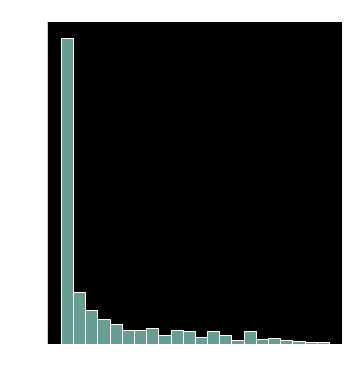

<Figure size 432x288 with 0 Axes>

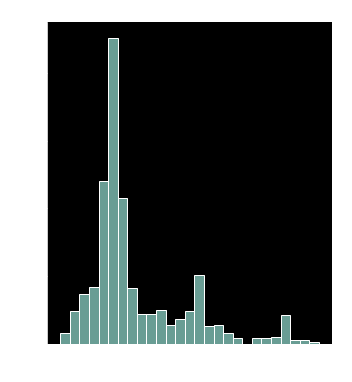

<Figure size 432x288 with 0 Axes>

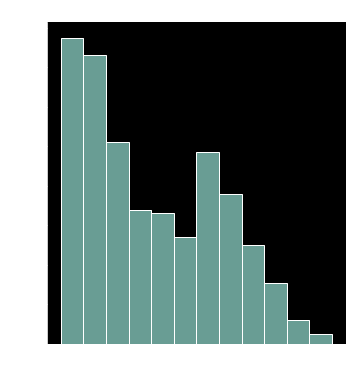

In [10]:
# How to preprocess data?
emo_map_path = pathlib.Path("/Users/mhankin/Projects/SZEmotionGoParticles/coarse_to_fine_emo_map.yaml")
plt.figure()
hypothesis_df = go_preprocess.preprocess(raw_data, logit_first=True, power=None, emo_map_path=emo_map_path)
sns.displot((- hypothesis_df * np.log(hypothesis_df)).sum(1))
plt.title("Logit first, then softmax")
plt.xlabel("Entropy")
plt.figure()
hypothesis_no_logit_df = go_preprocess.preprocess(raw_data, logit_first=False, power=None, emo_map_path=emo_map_path)
sns.displot((- hypothesis_no_logit_df * np.log(hypothesis_no_logit_df)).sum(1))
plt.title("Softmax")
plt.xlabel("Entropy")
plt.figure()
df = go_preprocess.preprocess(raw_data, logit_first=False, power=1.0, emo_map_path=emo_map_path)
sns.displot((- df * np.log(df)).sum(1))
plt.title("Simple sum-then-divide to normalize (BEST!)")
plt.xlabel("Entropy");

In [11]:
df.sample(10)

ambiguous  negative   neutral  positive
pid  stim          dc                                         
7097 neg_bugear    OT   0.107237  0.045775  0.000717  0.846271
8022 neu_cafe      HC   0.001435  0.157950  0.837419  0.003196
8016 neu_yawn      HC   0.957807  0.028074  0.002681  0.011438
7006 neg_larva     OT   0.010190  0.963704  0.005838  0.020268
7094 neu_cafe      PL   0.165569  0.056599  0.018788  0.759044
7039 neg_lightsout PL   0.017122  0.944000  0.006614  0.032264
7007 neg_coffer    OT   0.424971  0.120585  0.005076  0.449368
8019 neu_yawn      HC   0.044647  0.716268  0.208485  0.030601
8081 neg_larva     HC   0.007866  0.957620  0.005461  0.029053
7068 neg_lightsout OT   0.064578  0.898056  0.003504  0.033862

## Sample from model
Choose fairly arbitrary prior values, but we'll confirm the priors get swamped by the data afterwards.

Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...


Convergence achieved at 41000
Interrupted at 40,999 [81%]: Average Loss = -3,692.6
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [obs_mag, beta_drug, random_effects, re_rest, re_diag, beta, normative_emo]


Sampling 4 chains for 2_500 tune and 2_500 draw iterations (10_000 + 10_000 draws total) took 1101 seconds.
There were 63 divergences after tuning. Increase `target_accept` or reparameterize.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.
/Users/mhankin/anaconda3/lib/python3.8/site-packages/pymc3/distributions/multivariate.py:501: RuntimeWarning: invalid value encountered in true_divide
  samples = samples / samples.sum(-1, keepdims=True)
/Users/mhankin/anaconda3/lib/python3.8/site-packages/pymc3/distributions/transforms.py:461: RuntimeWarning: divide by zero encountered in log
  lx = np.log(x)
/Users/mhankin/anaconda3/lib/python3.8/site-packages/pymc3/distributions/transforms.py:463: RuntimeWarning: invalid value encountered in subtract
  y = lx[:-1] - shift


array([[<AxesSubplot:title={'center':'beta\nambiguous, ambiguous'}>,
        <AxesSubplot:title={'center':'beta\nambiguous, ambiguous'}>],
       [<AxesSubplot:title={'center':'beta\nambiguous, negative'}>,
        <AxesSubplot:title={'center':'beta\nambiguous, negative'}>],
       [<AxesSubplot:title={'center':'beta\nambiguous, neutral'}>,
        <AxesSubplot:title={'center':'beta\nambiguous, neutral'}>],
       [<AxesSubplot:title={'center':'beta\nambiguous, positive'}>,
        <AxesSubplot:title={'center':'beta\nambiguous, positive'}>],
       [<AxesSubplot:title={'center':'beta\nnegative, ambiguous'}>,
        <AxesSubplot:title={'center':'beta\nnegative, ambiguous'}>],
       [<AxesSubplot:title={'center':'beta\nnegative, negative'}>,
        <AxesSubplot:title={'center':'beta\nnegative, negative'}>],
       [<AxesSubplot:title={'center':'beta\nnegative, neutral'}>,
        <AxesSubplot:title={'center':'beta\nnegative, neutral'}>],
       [<AxesSubplot:title={'center':'beta\nneg

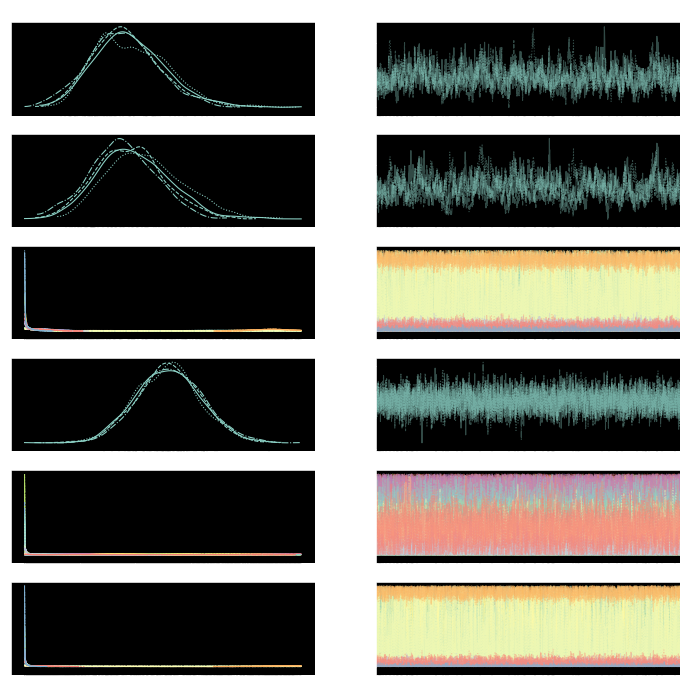

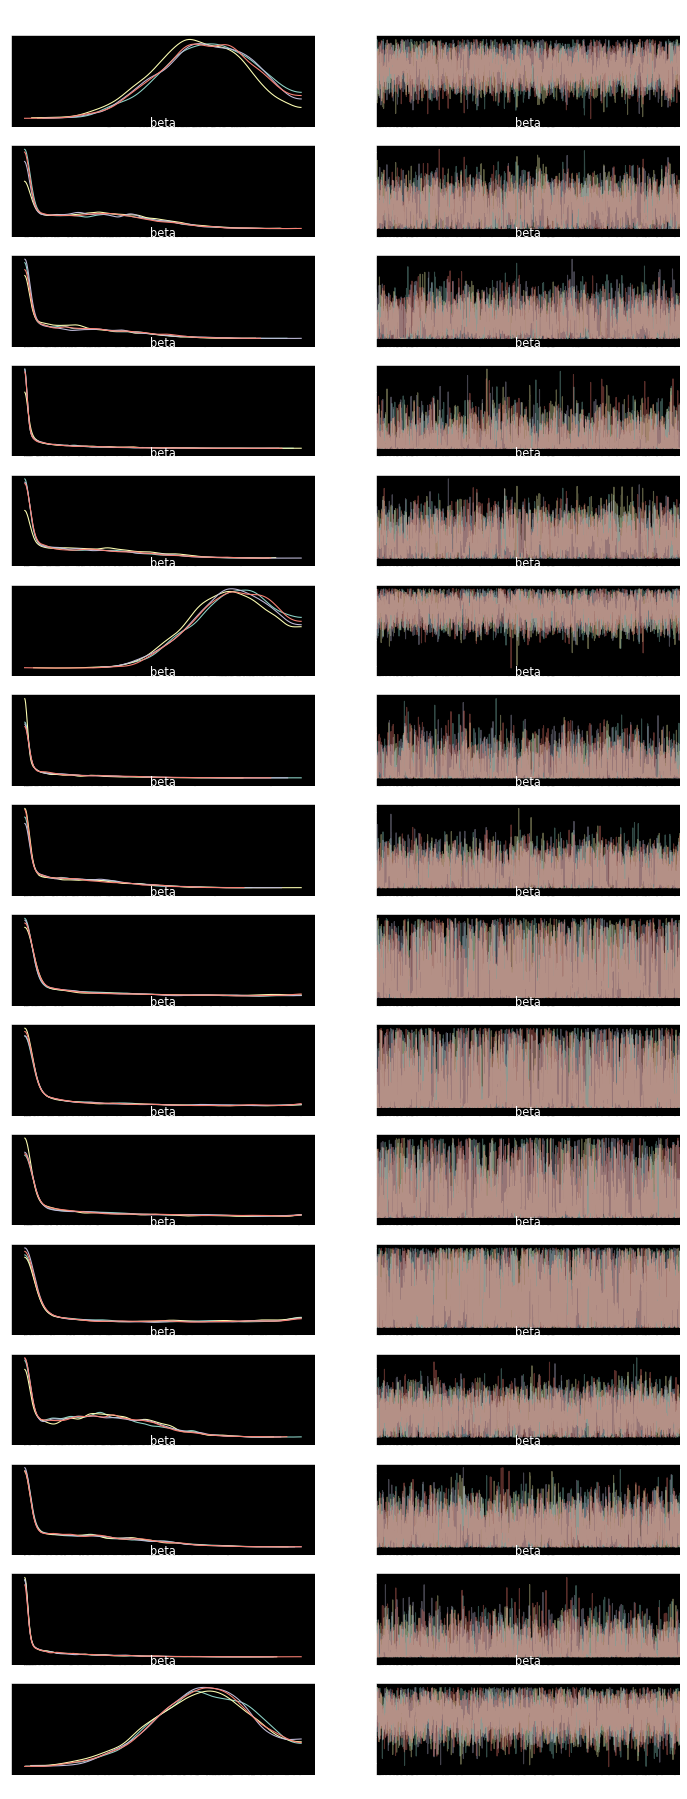

In [12]:

include_ot = True
model = go_model_module.bayesian_model(df.reset_index(), list(df.columns), include_ot=include_ot, inv_alpha=1.0)
samples = pm.sample(
    3500, 
    model=model, 
    return_inferencedata=True, 
    tune=3500, 
    chains=4, 
    init="advi+adapt_diag",
    n_init=50000
)

with model:
    prior = pm.sample_prior_predictive()
    prior = az.from_pymc3(prior=prior)
samples.extend(prior)

trace_vars = ["re_diag", "re_rest", "beta", "obs_mag", "normative_emo"]
if include_ot:
    trace_vars.append("beta_drug")
az.plot_trace(
    samples,
    var_names=trace_vars,
    compact=True,
)
az.plot_trace(
    samples,
    var_names=["beta"],
    compact=False,
)

In [17]:
display(samples)

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data
	> constant_data
	> prior
	> prior_predictive

<AxesSubplot:xlabel='beta_drug', ylabel='emo'>

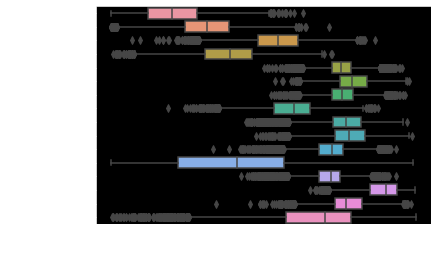

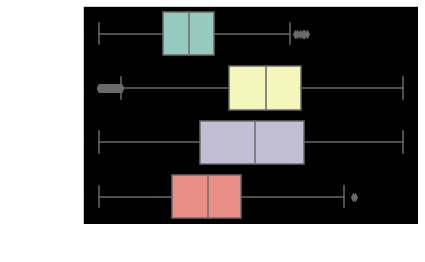

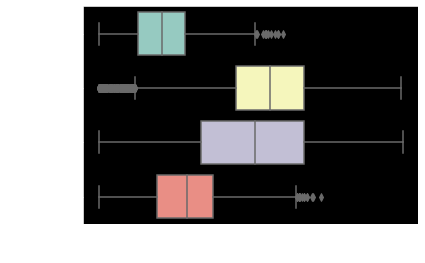

In [18]:
def calc_entropy(da: xr.DataArray, dim: str) -> xr.DataArray:
    return (-da * np.log(da)).sum(dim)

entropy_dim_map = {"normative_emo":"emo",
"beta":"emo_to",
"random_effects":"emo_to",
"beta_drug":"emo_to"
}
entropy_ds = xr.Dataset({var: calc_entropy(samples.posterior[var], dim) for var, dim in entropy_dim_map.items()})
emo_order = ["positive", "ambiguous", "neutral", "negative"]
plt.figure()
sns.boxplot(data=entropy_ds["normative_emo"].to_series().reset_index(), x="normative_emo", y="stim")
plt.figure()
sns.boxplot(data=entropy_ds["beta"].to_series().reset_index(), x="beta", y="emo", order=emo_order)
plt.figure()
sns.boxplot(data=entropy_ds["beta_drug"].to_series().reset_index(), x="beta_drug", y="emo", order=emo_order)



<AxesSubplot:xlabel='emo', ylabel='PostMeanEnt'>

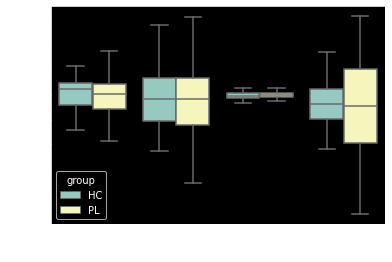

In [19]:
# Group random effect entropy comparison
# Medians should line up well between groups (difference was handled by group effect)
# but spreads may be different, indicating a difference in intragroup variabilty
# Very kludgey way of getting PID to group map
temp_df = pd.read_csv("/Users/mhankin/Projects/SZEmotionGoParticles/go_emotions_output_clean.csv")
temp_df = temp_df[temp_df["drugCondition"]!="OT"]
subject_group_map = {pid_dc[0]:pid_dc[1] for pid_dc, _ in temp_df.groupby(["id", "drugCondition"])}
re_entropyd_df = entropy_ds["random_effects"].to_series().reset_index()
re_entropyd_df["group"] = re_entropyd_df["pid"].apply(subject_group_map.get)
plt.figure()
person_emo_mean_posterior_entropy_df = re_entropyd_df.groupby(["group", "emo", "pid"])["random_effects"].mean()
person_emo_mean_posterior_entropy_df.name = "PostMeanEnt"
person_emo_mean_posterior_entropy_df = person_emo_mean_posterior_entropy_df.reset_index()
sns.boxplot(data=person_emo_mean_posterior_entropy_df, x="emo", y = "PostMeanEnt", hue="group", showfliers=False)


<ipython-input-24-ad9c4b66f8cd>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  re_entropy_min_df["VAR"] = "RE"


<AxesSubplot:xlabel='emo', ylabel='entropy'>

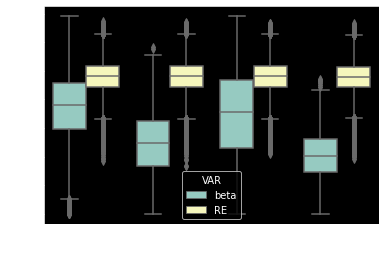

In [24]:
# Plot dist of random effect emotion entropy against beta entropies
# plt.figure()
# sns.boxplot(data=entropy_ds["normative_emo"].to_series().reset_index(), x="normative_emo", y="stim")
# plt.figure()
# sns.boxplot(data=entropy_ds["beta"].to_series().reset_index(), x="beta", y="emo", order=emo_order)
# plt.figure()
# sns.boxplot(data=entropy_ds["beta_drug"].to_series().reset_index(), x="beta_drug", y="emo", order=emo_order)
beta_emo_entropy_df = entropy_ds["beta"].to_series().reset_index()[["emo", "beta"]]
beta_emo_entropy_df.columns= ["emo", "entropy"]
beta_emo_entropy_df["VAR"] = "beta"
re_entropy_min_df = re_entropyd_df[["emo", "random_effects"]]
re_entropy_min_df.columns = ["emo", "entropy"]
re_entropy_min_df["VAR"] = "RE"
combined_df = pd.concat([beta_emo_entropy_df, re_entropy_min_df], 0, ignore_index=True)
sns.boxplot(data=combined_df, x="emo", y="entropy", hue="VAR")



In [10]:
emo_order

['positive', 'ambiguous', 'neutral', 'negative']

<AxesSubplot:xlabel='emo_to', ylabel='emo'>

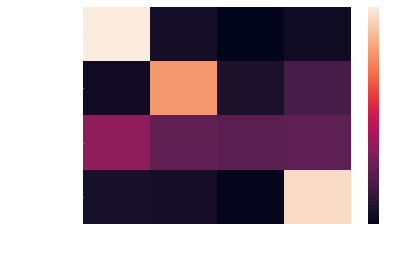

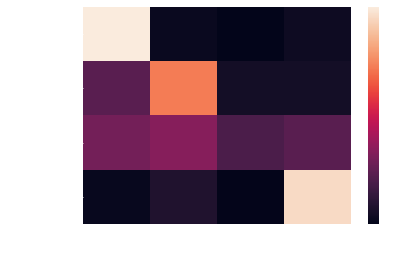

In [11]:
# Heatmap of posterior means of beta rotation matrices
plt.figure()
beta_posterior_means = samples.posterior["beta"].mean(["chain", "draw"]).to_series().unstack("emo_to")[emo_order].loc[emo_order, :]
sns.heatmap(beta_posterior_means)
plt.figure()
beta_drug_posterior_means = samples.posterior["beta_drug"].mean(["chain", "draw"]).to_series().unstack("emo_to")[emo_order].loc[emo_order, :]
sns.heatmap(beta_drug_posterior_means)

array([[<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:xlabel='re_diag'>],
       [<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:xlabel='re_rest'>],
       [<AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:xlabel='beta\nambiguous, ambiguous'>],
       [<AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:xlabel='beta\nambiguous, negative'>],
       [<AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:xlabel='beta\nambiguous, neutral'>],
       [<AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:xlabel='beta\nambiguous, positive'>],
       [<AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:xlabel='beta\nnegative, ambiguous'>],
       [<AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:xlabel='beta\nnegative, negative'>],
       [<AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:xlabel='beta\nnegative, neutral'>],
       [<AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:xlabel='beta\nnegative, positive'>],
       [<AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:xlabe

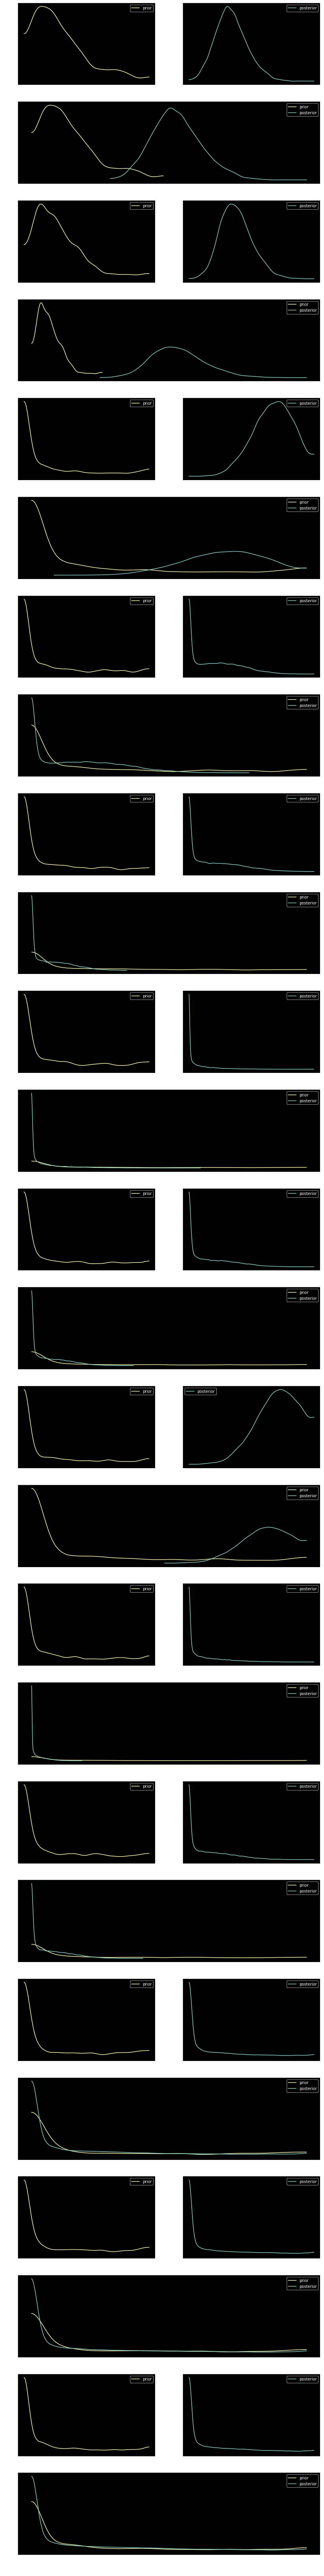

In [12]:
# Prior vs Posterior comparison
az.plot_dist_comparison(samples, var_names=trace_vars, )

In [5]:
rdf = raw_data.set_index(["id", "stimulus.x", "drugCondition"])
rdf

admiration  amusement     anger  annoyance  \
id   stimulus.x    drugCondition                                               
7001 joy_grandpa   OT               0.001042   0.001035  0.000845   0.000849   
     joy_baby      PL               0.960874   0.005966  0.000798   0.000671   
     neg_lightsout PL               0.005943   0.000347  0.000655   0.000911   
     neg_dying     PL               0.010091   0.011197  0.002459   0.002684   
     neu_cafe      PL               0.005375   0.000149  0.000234   0.000213   
...                                      ...        ...       ...        ...   
8110 neg_heart     HC               0.992814   0.000348  0.000402   0.000314   
     neu_yawn      HC               0.001368   0.000195  0.000657   0.002448   
     neg_nuts      HC               0.002175   0.000224  0.000335   0.001086   
     neg_bugear    HC               0.234895   0.000761  0.001220   0.002024   
     joy_dogfail   HC               0.098448   0.399928  0.001064   0.001010   

                                  approval    caring  confusion  curiosity  \
id   stimulus.x    drugCondition                                             
7001 joy_grandpa   OT             0.000364  0.000205   0.000353   0.000275   
     joy_baby      PL             0.008912  0.002192   0.001493   0.002151   
     neg_lightsout PL             0.328966  0.004237   0.001035   0.001401   
     neg_dying     PL             0.001347  0.001004   0.006593   0.033508   
     neu_cafe      PL             0.000557  0.000329   0.001421   0.001428   
...                                    ...       ...        ...        ...   
8110 neg_heart     HC             0.013754  0.001318   0.001773   0.003490   
     neu_yawn      HC             0.002445  0.001944   0.000564   0.000686   
     neg_nuts      HC             0.002600  0.021831   0.004273   0.001316   
     neg_bugear    HC             0.010232  0.207048   0.002048   0.002473   
     joy_dogfail   HC             0.012248  0.002849   0.003513   0.001513   

                                    desire  disappointment  ...      love  \
id   stimulus.x    drugCondition                            ...             
7001 joy_grandpa   OT             0.000160        0.000196  ...  0.000211   
     joy_baby      PL             0.002430        0.001351  ...  0.014209   
     neg_lightsout PL             0.000893        0.001667  ...  0.001895   
     neg_dying     PL             0.000919        0.016193  ...  0.001344   
     neu_cafe      PL             0.000345        0.002908  ...  0.000177   
...                                    ...             ...  ...       ...   
8110 neg_heart     HC             0.000240        0.001113  ...  0.000179   
     neu_yawn      HC             0.000705        0.000894  ...  0.000458   
     neg_nuts      HC             0.001355        0.156510  ...  0.000818   
     neg_bugear    HC             0.000479        0.010715  ...  0.000435   
     joy_dogfail   HC             0.000533        0.001117  ...  0.006039   

                                  nervousness   neutral  optimism     pride  \
id   stimulus.x    drugCondition                                              
7001 joy_grandpa   OT                0.000034  0.997159  0.000254  0.000082   
     joy_baby      PL                0.000156  0.001691  0.002541  0.004610   
     neg_lightsout PL                0.013901  0.003767  0.001340  0.014575   
     neg_dying     PL                0.001443  0.000899  0.002641  0.000758   
     neu_cafe      PL                0.000185  0.994895  0.000393  0.000386   
...                                       ...       ...       ...       ...   
8110 neg_heart     HC                0.000055  0.001404  0.001607  0.004624   
     neu_yawn      HC                0.000302  0.000791  0.001564  0.000428   
     neg_nuts      HC                0.632532  0.019171  0.001257  0.000725   
     neg_bugear    HC                0.000835  0.002227  0.025156  0.076329   
     joy_dogfail   HC       

In [26]:
aa, bb = pd.factorize(rdf.reset_index()["drugCondition"])
aa

array([0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0,
       0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1,
       1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0,
       0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1,
       1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0,
       0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1,
       1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0,

In [67]:
from importlib import reload
reload(go_model_module)

<module 'model' from '/Users/mhankin/Projects/SZEmotionGoParticles/model.py'>

In [56]:
zz = df.reset_index()
zz[zz["pid"]==7007]

pid         stim  dc  ambiguous  negative   neutral  positive
43  7007  joy_grandpa  OT   0.011815  0.337874  0.001247  0.649064
44  7007   neg_coffer  OT   0.424971  0.120585  0.005076  0.449368
45  7007    neg_heart  OT   0.041620  0.832120  0.000860  0.125400
46  7007     neu_yawn  OT   0.008242  0.011723  0.000952  0.979083
47  7007     neg_nuts  OT   0.008036  0.954106  0.001057  0.036801
48  7007   neg_bugear  OT   0.004095  0.976614  0.001345  0.017946
49  7007  joy_dogfail  OT   0.009022  0.018571  0.000278  0.972129

Only 250 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...


Finished [100%]: Average Loss = -1,688.9
Multiprocess sampling (3 chains in 4 jobs)
NUTS: [obs_mag, personal_rotation, re_rest, re_diag, beta_multipliers, normative_emo]


Sampling 3 chains for 250 tune and 250 draw iterations (750 + 750 draws total) took 131 seconds.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8803818490223878, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.
/Users/mhankin/anaconda3/lib/python3.8/site-packages/pymc3/distributions/multivariate.py:501: RuntimeWarning: invalid value encountered in true_divide
  samples = samples / samples.sum(-1, keepdims=True)
/Users/mhankin/anaconda3/lib/python3.8/site-packages/pymc3/distributions/transforms.py:461: RuntimeWarning: divide by zero encountered in log
  lx = np.log(x)
/Users/mhankin/anaconda3/lib/python3.8/site-packages/pymc3/distributions/transforms.py:463: RuntimeWarning: invalid value encountered

array([[<AxesSubplot:title={'center':'beta_multipliers\nambiguous, ambiguous'}>,
        <AxesSubplot:title={'center':'beta_multipliers\nambiguous, ambiguous'}>],
       [<AxesSubplot:title={'center':'beta_multipliers\nambiguous, negative'}>,
        <AxesSubplot:title={'center':'beta_multipliers\nambiguous, negative'}>],
       [<AxesSubplot:title={'center':'beta_multipliers\nambiguous, neutral'}>,
        <AxesSubplot:title={'center':'beta_multipliers\nambiguous, neutral'}>],
       [<AxesSubplot:title={'center':'beta_multipliers\nambiguous, positive'}>,
        <AxesSubplot:title={'center':'beta_multipliers\nambiguous, positive'}>],
       [<AxesSubplot:title={'center':'beta_multipliers\nnegative, ambiguous'}>,
        <AxesSubplot:title={'center':'beta_multipliers\nnegative, ambiguous'}>],
       [<AxesSubplot:title={'center':'beta_multipliers\nnegative, negative'}>,
        <AxesSubplot:title={'center':'beta_multipliers\nnegative, negative'}>],
       [<AxesSubplot:title={'center'

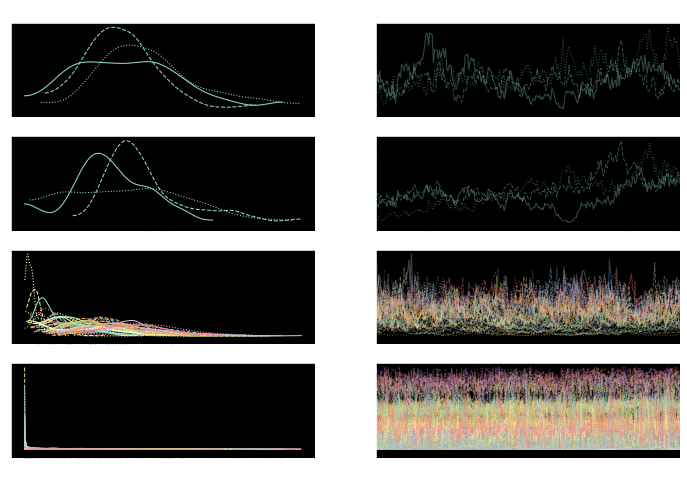

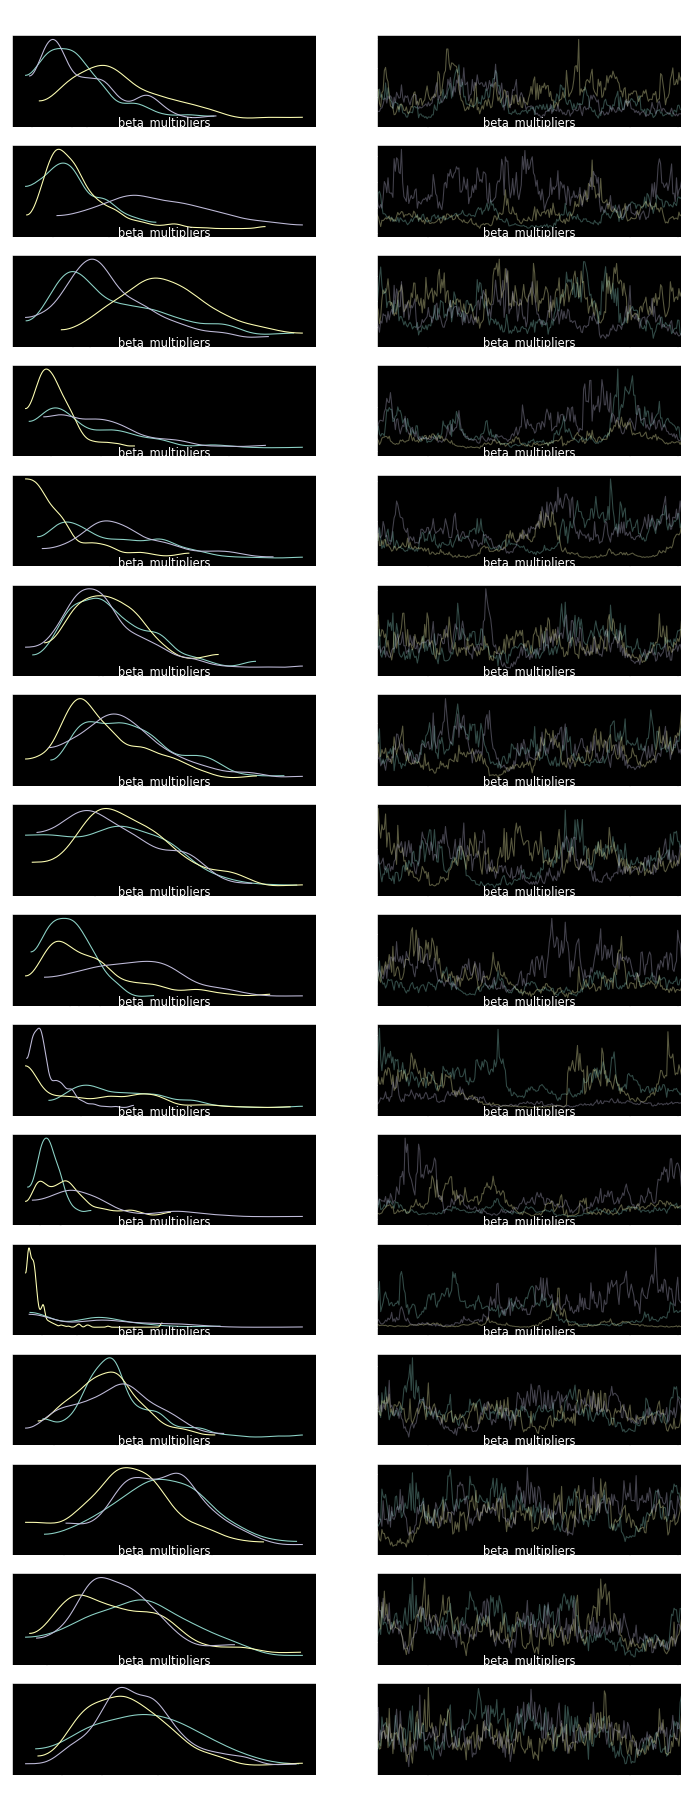

In [69]:

add_model = go_model_module.additive_model(df.reset_index(), list(df.columns), include_ot=False, inv_alpha=1.0)
add_samples = pm.sample(
    250, 
    model=add_model, 
    return_inferencedata=True, 
    tune=250, 
    chains=3, 
    init="advi+adapt_diag",
    n_init=5000,
)

with add_model:
    prior = pm.sample_prior_predictive()
    prior = az.from_pymc3(prior=prior)
add_samples.extend(prior)

trace_vars = ["re_diag", "re_rest", "beta_multipliers", "normative_emo", "obs_mag"]
az.plot_trace(
    add_samples,
    var_names=trace_vars,
    compact=True,
)
az.plot_trace(
    add_samples,
    var_names=["beta_multipliers"],
    compact=False,
)

<AxesSubplot:xlabel='emo_to', ylabel='emo'>

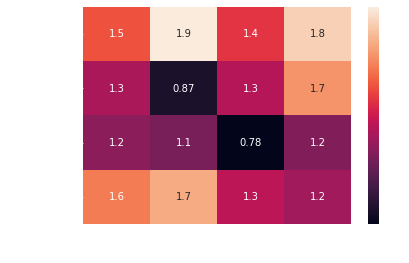

In [58]:
bm_df = add_samples.posterior["beta_multipliers"].mean(["chain", "draw"]).to_series().unstack("emo_to")

sns.heatmap(bm_df[emo_order].loc[emo_order, :], annot=True)

array([[<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:xlabel='re_diag'>],
       [<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:xlabel='re_rest'>],
       [<AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:xlabel='beta_multipliers\nambiguous, ambiguous'>],
       [<AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:xlabel='beta_multipliers\nambiguous, negative'>],
       [<AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:xlabel='beta_multipliers\nambiguous, neutral'>],
       [<AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:xlabel='beta_multipliers\nambiguous, positive'>],
       [<AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:xlabel='beta_multipliers\nnegative, ambiguous'>],
       [<AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:xlabel='beta_multipliers\nnegative, negative'>],
       [<AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:xlabel='beta_multipliers\nnegative, neutral'>],
       [<AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:xlabel='beta_multip

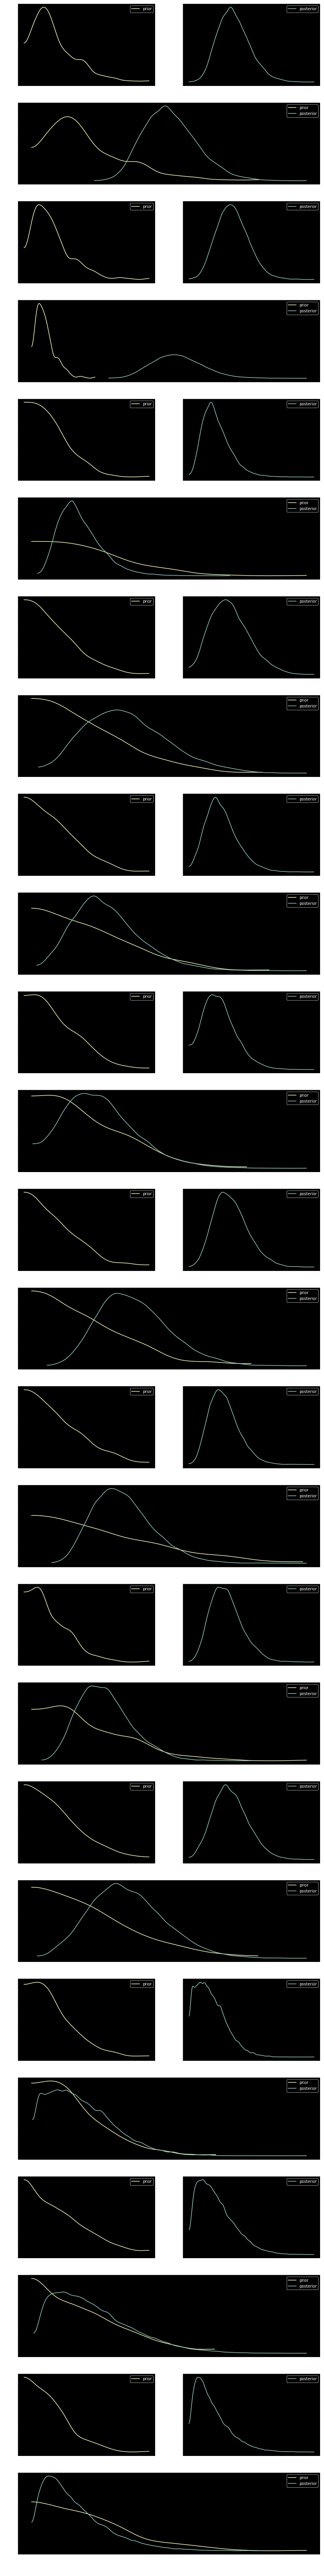

In [59]:
az.plot_dist_comparison(add_samples, var_names=trace_vars)

In [60]:
add_samples

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data
	> constant_data
	> prior
	> prior_predictive

In [52]:
reload(go_model_module)

<module 'model' from '/Users/mhankin/Projects/SZEmotionGoParticles/model.py'>

In [63]:
zz = add_samples.posterior["rotation_alpha"].mean(["chain", "draw"]).sel({"pid":[7001, 8109]})
zz

<xarray.DataArray 'rotation_alpha' (pid: 2, emo: 4, emo_to: 4)>
array([[[28.18804779, 16.41582289, 12.67601464, 12.44681254],
        [16.96743444, 40.04378435, 12.83794462, 15.84580311],
        [11.16553748, 11.49505606, 25.56082856, 11.67886171],
        [18.82001252, 18.05930247, 14.12078917, 48.68136336]],

       [[32.76560345,  9.92499297,  9.92499297,  9.92499297],
        [ 9.92499297, 32.76560345,  9.92499297,  9.92499297],
        [ 9.92499297,  9.92499297, 32.76560345,  9.92499297],
        [ 9.92499297,  9.92499297,  9.92499297, 32.76560345]]])
Coordinates:
  * emo      (emo) <U9 'ambiguous' 'negative' 'neutral' 'positive'
  * emo_to   (emo_to) <U9 'ambiguous' 'negative' 'neutral' 'positive'
  * pid      (pid) int64 7001 8109

In [65]:
(100.0 * zz / zz.sum("emo_to")).round()

<xarray.DataArray 'rotation_alpha' (pid: 2, emo: 4, emo_to: 4)>
array([[[40., 24., 18., 18.],
        [20., 47., 15., 18.],
        [19., 19., 43., 19.],
        [19., 18., 14., 49.]],

       [[52., 16., 16., 16.],
        [16., 52., 16., 16.],
        [16., 16., 52., 16.],
        [16., 16., 16., 52.]]])
Coordinates:
  * emo      (emo) <U9 'ambiguous' 'negative' 'neutral' 'positive'
  * emo_to   (emo_to) <U9 'ambiguous' 'negative' 'neutral' 'positive'
  * pid      (pid) int64 7001 8109

In [66]:
np.tile(np.array([[1,2], [3, 4]])[None, ...], [3, 1, 1])

array([[[1, 2],
        [3, 4]],

       [[1, 2],
        [3, 4]],

       [[1, 2],
        [3, 4]]])

In [70]:
add_samples

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data
	> constant_data
	> prior
	> prior_predictive